In [1]:
import sys
sys.path.append('../../lib/')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from scipy.stats import linregress
from jax.example_libraries.optimizers import adam, pack_optimizer_state
from hetero_simulation.archive.agent import ces_utility, log_utility
from hetero_simulation.ml.utils import *
from hetero_simulation.econ_models.krusell_smith import neural_network, prices, fischer_burmeister, next_state, batch_loss, simulate_state_forward
from hetero_simulation.econ_models.krusell_smith import params0, config, n, mb, k, m, nn_shapes, generate_random_state, n_forward, n_epoch

In [2]:
_, _, get_params = adam(step_size=0.001)
saved_state = pickle.load(open(f'../models/ks_model_{k}_final.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_state)
params = get_params(opt_state)

key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
keys = jax.random.split(key, 2)
Xs, Zs, Es, key = generate_random_state(params, config, key, n_forward=2000)

### Assumed Parameter Values

In [8]:
config

{'alpha': 0.36,
 'beta': 0.96,
 'delta': 0.025,
 'sigma_z': 0.01,
 'sigma_e': DeviceArray(0.08717798, dtype=float32, weak_type=True),
 'rho_z': 0.95,
 'rho_e': 0.9}

As in MMW, both aggregate productivity and idiosyncratic productivity are assumed to follow an AR(1) process, with parametes rho_z/e and sigma_z/e respectively. This is a deviation from the original Krusell-Smith, in which these follow a joint, discrete, first order Markov process.

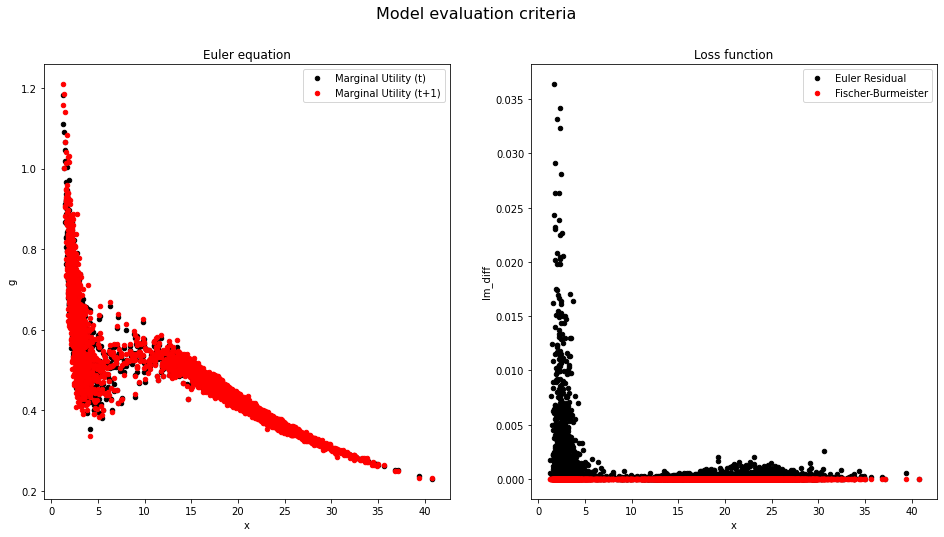

In [3]:
u = log_utility()

Z1s, E1s = next_state(Zs, Es, config, key)
Rs, Ws = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(Xs, Zs, Es)
ws = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(X, E))(Xs, Es, Rs, Ws)
outputs = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i]))(jnp.arange(k)))(Xs, Zs, Es, ws)
cs = outputs[..., 0]
lms = outputs[..., 1]
c_rels = cs / ws
X1s = ws - cs
R1s, W1s = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(X1s, Z1s, E1s)
w1s = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(X, E))(X1s, E1s, R1s, W1s)
c1s = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i])[0])(jnp.arange(k)))(X1s, Z1s, E1s, w1s)

u = lambda c: log_utility()(c)
gs = jax.vmap(lambda R, cs: jax.vmap(lambda c: config['beta'] * R * jax.grad(u)(c))(cs))(R1s, c1s)
ups = jax.grad(u)(cs)
us = jax.vmap(jax.vmap(u))(cs)

g_diff = (jax.vmap(lambda g, up, lm: (g / up) - lm)(gs.reshape(-1, 1), ups.reshape(-1, 1), lms.reshape(-1, 1)))**2
lm_diff = (jax.vmap(lambda c, lm: fischer_burmeister(1 - c, 1 - lm))(c_rels.reshape(-1, 1), lms.reshape(-1, 1)))**2

df = pd.DataFrame(jnp.concatenate([ws.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                   w1s.reshape(-1, 1), lms.reshape(-1, 1),
                                   gs.reshape(-1, 1), c_rels.reshape(-1, 1),
                                   cs.reshape(-1, 1), us.reshape(-1, 1), ups.reshape(-1, 1),
                                   g_diff.reshape(-1, 1), lm_diff.reshape(-1, 1)], axis=1))
df.columns = ['x', 'Z', 'e', 'x_prime', 'lm', 'g', 'c_star_rel', 'c_star', 'u', 'u_prime', 'g_diff', 'lm_diff']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
df['gf'] = df['g'] / df['u_prime']
df.plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes[0])
df.plot(x='x', y='g', kind='scatter', color='red', ax=axes[0])
df.plot(x='x', y='g_diff', kind='scatter', color='black', ax=axes[1])
df.plot(x='x', y='lm_diff', kind='scatter', color='red', ax=axes[1])

_ = fig.suptitle(f'Model evaluation criteria', fontsize=16)
_ = axes[0].set_title('Euler equation')
_ = axes[1].set_title('Loss function')
_ = axes[0].legend(labels=['Marginal Utility (t)', 'Marginal Utility (t+1)'])
_ = axes[1].legend(labels=['Euler Residual', 'Fischer-Burmeister'])

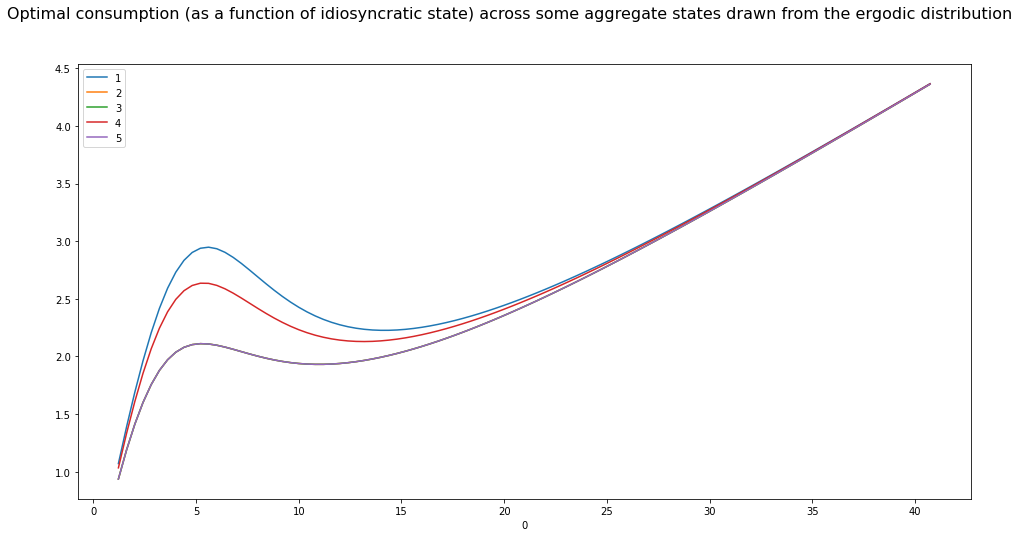

In [4]:
key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
idx = jax.random.choice(key, jnp.arange(n), shape=(5,))

X = Xs[idx]
Z = Zs[idx]
E = Es[idx]
e = E[:, 0]

x_range = jnp.linspace(jnp.min(ws), jnp.max(ws), 100)
c_range = jax.vmap(lambda X, E, Z, e: jax.vmap(lambda x: neural_network(params, X, E, Z, e, x)[0])(x_range))(X, Z, E, e)
data = pd.DataFrame(jnp.concatenate((x_range.reshape(-1, 1), c_range.T), axis=1))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = data.plot(x=0, y=[1, 2, 3, 4, 5], ax=ax)
_ = fig.suptitle(f'Optimal consumption (as a function of idiosyncratic state) across some aggregate states drawn from the ergodic distribution', fontsize=16)

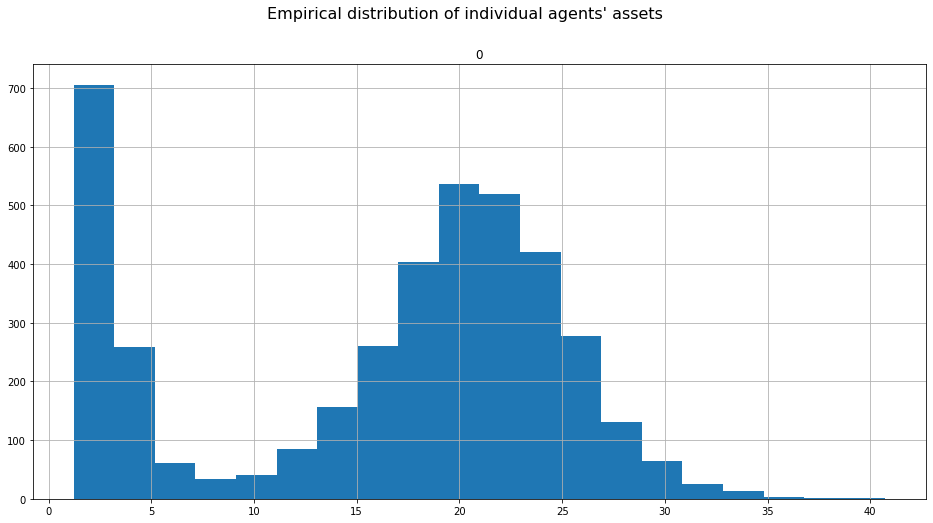

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = pd.DataFrame(ws.reshape(-1, 1)).hist(ax=ax, bins=20)
_ = fig.suptitle(f'Empirical distribution of individual agents\' assets', fontsize=16)

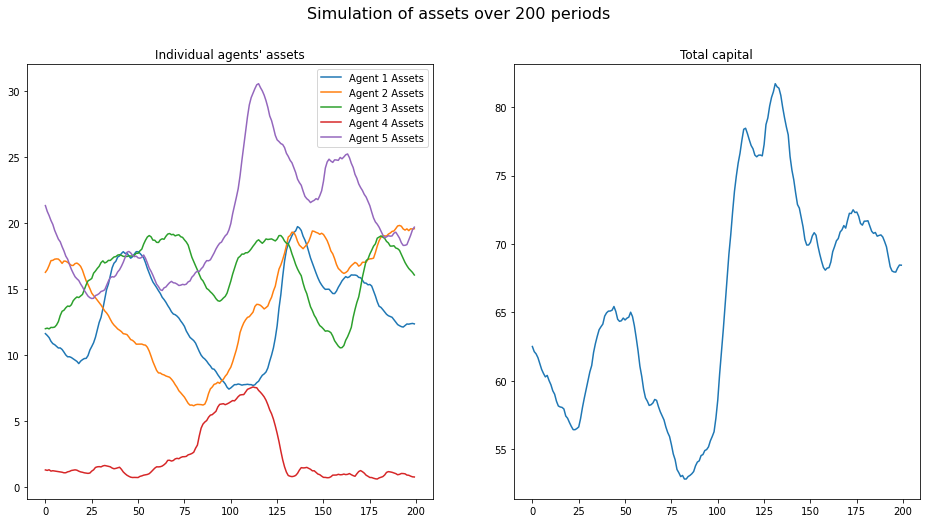

In [6]:
n_periods = 200
X_range = Xs[jnp.newaxis, ...]
for i in range(n_periods - 1):
    Xs, Zs, Es, key = simulate_state_forward(params, config, Xs, Zs, Es, key, 1)
    X_range = jnp.concatenate((X_range, Xs[jnp.newaxis, ...]))

states = pd.DataFrame(X_range[:, 1, :])
agg_states = states.sum(axis=1)
states = pd.concat((states, agg_states), axis=1)
states.columns = [f'Agent {i+1} Assets' for i in range(k)] + ['Total Assets in Economy']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
_ = states.plot(y=[f'Agent {i+1} Assets' for i in range(k)], ax=axes[0])
_ = states.plot(y=['Total Assets in Economy'], ax=axes[1], legend=False)
_ = fig.suptitle(f'Simulation of assets over {n_periods} periods', fontsize=16)
_ = axes[0].set_title(f'Individual agents\' assets', fontsize=12)
_ = axes[1].set_title(f'Total capital', fontsize=12)

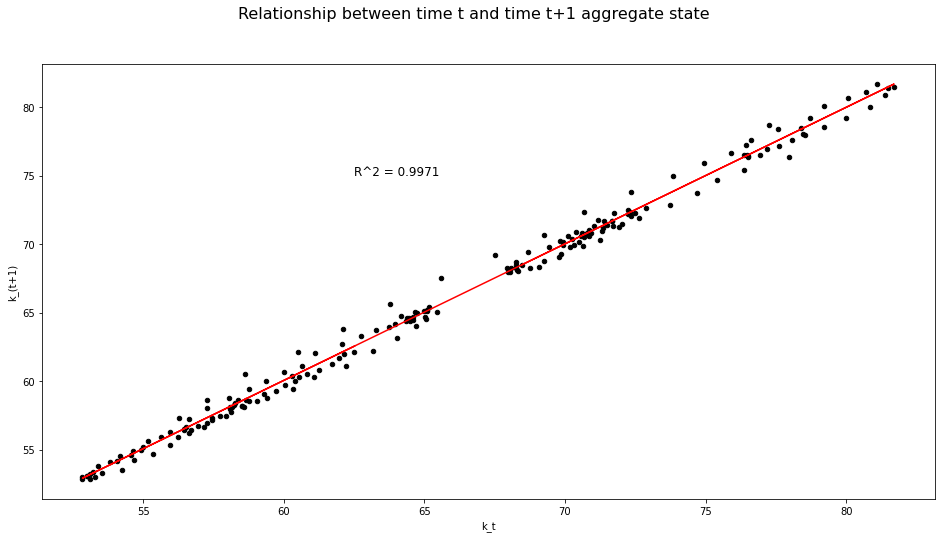

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
agg_assets = pd.concat((agg_states, agg_states.shift(-1)), axis=1).dropna()
agg_assets.columns = ['k_t', 'k_(t+1)']
m, b, r2, p, e = linregress(agg_assets['k_t'], agg_assets['k_(t+1)'])
x = np.linspace(agg_assets['k_t'].min(), agg_assets['k_(t+1)'].max(), 100)
agg_assets['reg_line'] = m * agg_assets['k_t'] + b
agg_assets.plot(x='k_t', y='k_(t+1)', kind='scatter', ax=ax, color='black')
agg_assets.plot(x='k_t', y='reg_line', kind='line', ax=ax, color='red', legend=False)
_ = ax.annotate(f'R^2 = {r2:.4f}', (62.5, 75), fontsize=12)
_ = fig.suptitle(f'Relationship between time t and time t+1 aggregate state', fontsize=16)